<a href="https://colab.research.google.com/github/adrianmacri/Favorita-Project/blob/main/Project_Times_Series_Adrian_Macri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navigate to the working directory
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
# Where am I
%pwd

'/content/drive/MyDrive'

In [5]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [6]:
pwd

'/content/drive/MyDrive'

In [7]:
# Load the dataset hokidays_events in Drive
df_holidays_events = pd.read_csv('favorita/holidays_events.csv')

In [8]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
# Load auxiliary datasets
df_stores = pd.read_csv('favorita/stores.csv')
df_items = pd.read_csv('favorita/items.csv')
df_transactions = pd.read_csv('favorita/transactions.csv')
df_oil = pd.read_csv('favorita/oil.csv')

In [10]:
# We want to filter for Guayas
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
# Filter for stores located in the state of Guayas
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].tolist()

In [12]:
# Load and filter train dataset in chunks for memory efficiency
chunk_size = 10 ** 6

filtered_chunks = list()

for chunk in pd.read_csv('favorita/train.csv', chunksize = chunk_size):
  chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
  filtered_chunks.append(chunk_filtered)

  del chunk

df_train = pd.concat(filtered_chunks, ignore_index = True)
del filtered_chunks

/tmp/ipython-input-12-1302667297.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('favorita/train.csv', chunksize = chunk_size):


In [13]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


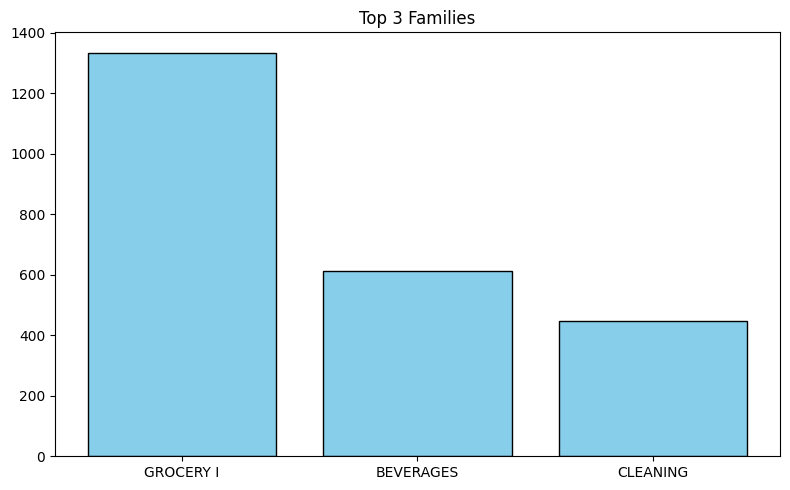

In [14]:
# Identify top 3 item families by item count
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family','Item Count']
top_3_families = items_per_family.head(3) # [:3]

# Plot top 3 item families
plt.figure(figsize = (8,5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'],
        color = 'skyblue', edgecolor = 'black')
plt.title('Top 3 Families')
plt.tight_layout()
plt.show()

In [15]:
# The top 3 categories
top_3_families['Family'].unique()

array(['GROCERY I', 'BEVERAGES', 'CLEANING'], dtype=object)

In [16]:
# Filter train dataset for items belonging to top 3 families
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].tolist()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

In [17]:
# Numbers the columns and linies
df_train.shape

(14745768, 6)

In [18]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN
5,18794,2013-01-02,24,105737,17.0,NaN


In [19]:
# Counts the onpromotion
df_train['onpromotion'].value_counts()

,count
onpromotion,
False,11319196
True,679297


In [20]:
# Handle missing promotion values
df_train.fillna({'onpromotion': False}, inplace=True)

/tmp/ipython-input-20-2161583476.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train.fillna({'onpromotion': False}, inplace=True)


In [21]:
negative_sales = df_train[df_train['unit_sales']<0]
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
96414,564108,2013-01-15,51,627885,-36.0,False
132903,787522,2013-01-21,24,211205,-5.0,False


$$z_\text{score} = \frac{X-\mu}{\sigma}$$

In [22]:
# Remove negative unit sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x,0))

In [23]:
# Calculate Z-score to detect outliers
def calculate_store_item_zscore(group):
  mean_sales = group['unit_sales'].mean()
  std_sales = group['unit_sales'].std()
  group['z_score'] = (group['unit_sales'] - mean_sales)/(std_sales if std_sales !=0 else 1)
  return group

In [24]:
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

/tmp/ipython-input-24-3380579669.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


In [25]:
# Filter outliers with Z-score > 5
outliers = df_train_grouped[df_train_grouped['z_score']>5]
outliers

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,False,7.946399
286,59775862,2015-10-20,24,99197,14.0,False,5.822016
289,60322807,2015-10-26,24,99197,19.0,False,8.276173
721,15717753,2013-12-19,24,103520,27.0,False,6.642670
770,18886543,2014-02-13,24,103520,22.0,False,5.154400
...,...,...,...,...,...,...,...
14741488,114286905,2017-05-01,51,2048609,48.0,False,7.830664
14742765,104195298,2017-01-25,51,2054291,21.0,False,6.141217
14743164,122354227,2017-07-16,51,2057033,21.0,True,5.247882
14743658,117045510,2017-05-27,51,2058907,12.0,False,5.054512


In [26]:
# Convert date column to datetime and create complete date range
df_train['date'] = pd.to_datetime(df_train['date'])

2025-01-01
2025-01-05



2025-01-01
2025-01-02
2025-01-03
2025-01-04
2025-01-05

In [27]:
min_date = df_train['date'].min()
max_date = df_train['date'].max()

In [28]:
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date,
                                                      freq='D')})

In [29]:
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


1 2025-01-01 1
2 2025-01-01 1
1 2025-01-02 3



1 2025-01-01 1
2 2025-01-01 1
1 2025-01-02 3
2 2025-01-02 0

In [30]:
# Fill missing dates for each store-item combination
store_item_combinations = df_train[['store_nbr','item_nbr']].drop_duplicates()

all_combinations = store_item_combinations.merge(full_date_range, how = 'cross')
all_combinations

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
35069351,51,2123791,2017-08-11
35069352,51,2123791,2017-08-12
35069353,51,2123791,2017-08-13
35069354,51,2123791,2017-08-14


In [31]:
df_filled = all_combinations.merge(df_train,
                                   on = ['store_nbr', 'item_nbr', 'date'],
                                   how ='left')
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)
df_filled.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,False
1,24,105574,2013-01-03,59692.0,1.0,False
2,24,105574,2013-01-04,99664.0,3.0,False
3,24,105574,2013-01-05,140805.0,4.0,False
4,24,105574,2013-01-06,182800.0,7.0,False


In [32]:
df_filled.groupby(['store_nbr','date'])['unit_sales'].sum().head()

store_nbr  date      
24         2013-01-02    7751.0
           2013-01-03    6802.0
           2013-01-04    6525.0
           2013-01-05    8243.0
           2013-01-06    7587.0
Name: unit_sales, dtype: float64

In [33]:
df_train = df_filled
del df_filled

In [34]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,False
1,24,105574,2013-01-03,59692.0,1.0,False
2,24,105574,2013-01-04,99664.0,3.0,False
3,24,105574,2013-01-05,140805.0,4.0,False
4,24,105574,2013-01-06,182800.0,7.0,False


In [35]:
# Create date-based features
df_train['date'] = pd.to_datetime(df_train['date'])

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [36]:
# Calculate 7-day rolling average of unit sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['store_nbr','item_nbr'])['unit_sales'].transform(lambda x: x.rolling(7).mean())

In [37]:
df_train['unit_sales_7d_avg'].head(14)

,unit_sales_7d_avg
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,4.714286
7,4.000000
8,4.285714
9,4.714286


1 NaN
2 1.5
3 2.5
4 3.5
5 4.5
6 5.5

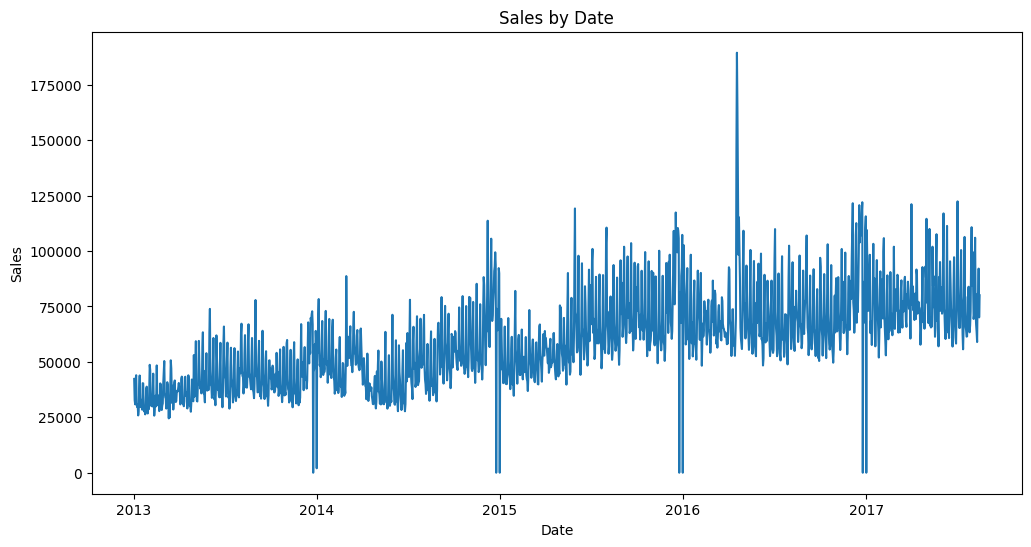

In [38]:
# Plot total sales over time
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

plt.figure(figsize = (12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Sales by Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

**Interpretation:**

Seasonal or weekly trends:

You might notice recurring peaks and drops—this could indicate weekly seasonality (e.g., weekends vs weekdays).

Look for repeating patterns every 7 days, suggesting that sales are higher on specific days of the week, such as Fridays or Saturdays.

Promotional spikes:

Any sudden sharp increase in sales may be due to promotions or special events.

You can later compare these spikes with the onpromotion feature to confirm if they align.

Anomalies or dips:

Significant dips might be caused by holidays, stockouts, or missing data.

If some days show unusually low sales, it’s worth checking if those dates align with public holidays or store closures.

Data stability:

A consistent level of activity across the timeline suggests stable demand.

If sales fluctuate too wildly without a pattern, it may imply high noise or the need for better features to explain variance.

In [39]:
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()
sales_by_month

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2013,985816.000,963374.000,1126816.000,1064720.000,1304490.000,1322507.000,1272269.000,1449398.000,1321202.000,1283535.000,1224938.000,1617073.000
2014,1606597.284,1244166.000,1756789.875,1167219.086,1191326.104,1195433.436,1572924.145,1413351.128,1639377.080,1706047.065,1746691.571,2315496.978
2015,1479434.799,1415871.851,1605824.582,1562518.753,1905258.601,1955912.032,2077212.503,2134624.519,2201828.707,2239073.671,2038885.207,2632298.877
2016,2122601.422,1965544.737,2064289.713,2510966.950,2235713.457,1985978.396,2143978.484,2180870.654,2036357.180,2125248.929,2185801.524,2809818.408
2017,2318440.020,2066607.343,2355300.270,2327855.269,2466776.470,2247466.132,2427228.829,1184526.522,NaN,NaN,NaN,NaN


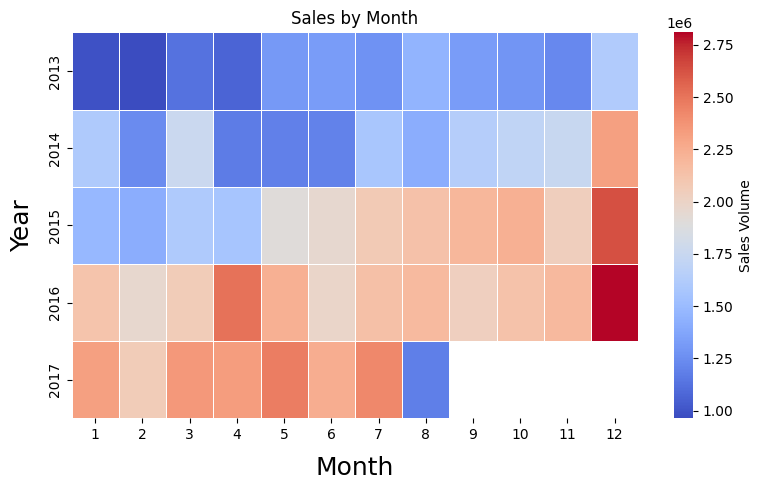

In [40]:
# Heatmap of sales by year and month
plt.figure(figsize = (8,5))
sns.heatmap(sales_by_month,
            cmap = 'coolwarm',
            linewidth = 0.5,
            linecolor = 'white',
            cbar_kws = {'label': 'Sales Volume'})

plt.title('Sales by Month')
plt.xlabel('Month', fontsize = 18, labelpad = 10)
plt.ylabel('Year', fontsize = 18, labelpad = 10)
plt.tight_layout()
plt.show()

**Interpretation:**

Seasonal patterns:

You can easily spot seasonal trends across years. For example, December consistently shows red shades, it likely indicates a holiday shopping peak.

Some months (e.g., January or July) are consistently cooler, it may suggest post-holiday drops or low-season effects.

Year-to-year variation:

This view also allows comparison across years. If one entire year is cooler than the others, it might reflect a drop in demand, data quality issues, or economic effects.

In [41]:
# Analyze impact of holidays on sales
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

In [42]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [43]:
df_train_no_zero = df_train[df_train['unit_sales'] > 0]

sample = df_train_no_zero.sample(n = 500_000)

df_train_holiday = pd.merge(sample, df_holidays_events, on='date', how = 'left')

holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

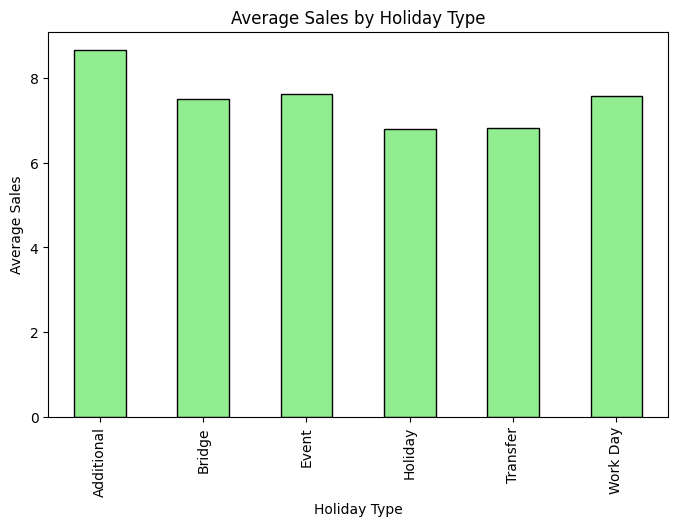

In [44]:
# Graph Average Sales by Holiday Type
plt.figure(figsize = (8,5))
holiday_sales.plot(kind='bar', color = 'lightgreen', edgecolor='black')
plt.title('Average Sales by Holiday Type')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.show()

##Prepare data for consumn min RAM

In [45]:
# Caminho para os dados
path = '/content/drive/MyDrive/favorita/'

# 1. Definir colunas e tipos para economizar RAM
usecols = ['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion']
dtypes = {
    'store_nbr': 'int8',
    'item_nbr': 'int32',
    'unit_sales': 'float32'
    # onpromotion: vamos tratar depois
}

# 2. Selecionar lojas e famílias
guayas_stores = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].tolist()
top_families = df_items['family'].value_counts().head(3).index.tolist()
items_top3 = df_items[df_items['family'].isin(top_families)]['item_nbr'].tolist()

# 3. Inicializar a lista
filtered_chunks = []
chunksize = 10**6

# 4. Ler e filtrar os dados
for chunk in pd.read_csv(path + 'train.csv',
                         usecols=usecols,
                         dtype=dtypes,
                         parse_dates=['date'],
                         chunksize=chunksize):

    # Tratar valores ausentes em 'onpromotion'
    chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype(bool)

    # Aplicar filtros
    chunk = chunk[chunk['store_nbr'].isin(guayas_stores)]
    chunk = chunk[chunk['item_nbr'].isin(items_top3)]

    filtered_chunks.append(chunk)
    del chunk

# 5. Concatenar tudo em um único DataFrame
df = pd.concat(filtered_chunks, ignore_index=True)
del filtered_chunks


/tmp/ipython-input-45-31668202.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype(bool)
/tmp/ipython-input-45-31668202.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype(bool)
/tmp/ipython-input-45-31668202.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

In [46]:
# Salvar o DataFrame filtrado como CSV no Google Drive
output_path = '/content/drive/MyDrive/favorita/guayas_prepared.csv'
df.to_csv(output_path, index=False)
print(f'Dataset salvo com sucesso em: {output_path}')


Dataset salvo com sucesso em: /content/drive/MyDrive/favorita/guayas_prepared.csv


In [47]:
df = pd.read_csv('/content/drive/MyDrive/favorita/guayas_prepared.csv', parse_dates=['date'])

##Building an XGBoost demand-forecast model (and optionally an LSTM) for the Guayas region dataset

Load optimized dataset

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (if not already)
from google.colab import drive
drive.mount('/content/drive')

# Define path to preprocessed CSV
csv_path = '/content/drive/MyDrive/favorita/guayas_prepared.csv'

# Optimize memory usage
usecols = ['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion']
dtypes = {
    'store_nbr': 'int8',
    'item_nbr': 'int32',
    'unit_sales': 'float32',
    'onpromotion': 'boolean'
}

# Load data
df = pd.read_csv(csv_path, usecols=usecols, dtype=dtypes, parse_dates=['date'])
df.info()
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14745768 entries, 0 to 14745767
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int8          
 2   item_nbr     int32         
 3   unit_sales   float32       
 4   onpromotion  boolean       
dtypes: boolean(1), datetime64[ns](1), float32(1), int32(1), int8(1)
memory usage: 267.2 MB


,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-02,24,105574,12.0,False
1,2013-01-02,24,105575,2.0,False
2,2013-01-02,24,105577,1.0,False
3,2013-01-02,24,105693,7.0,False
4,2013-01-02,24,105737,17.0,False


Explore sales by date

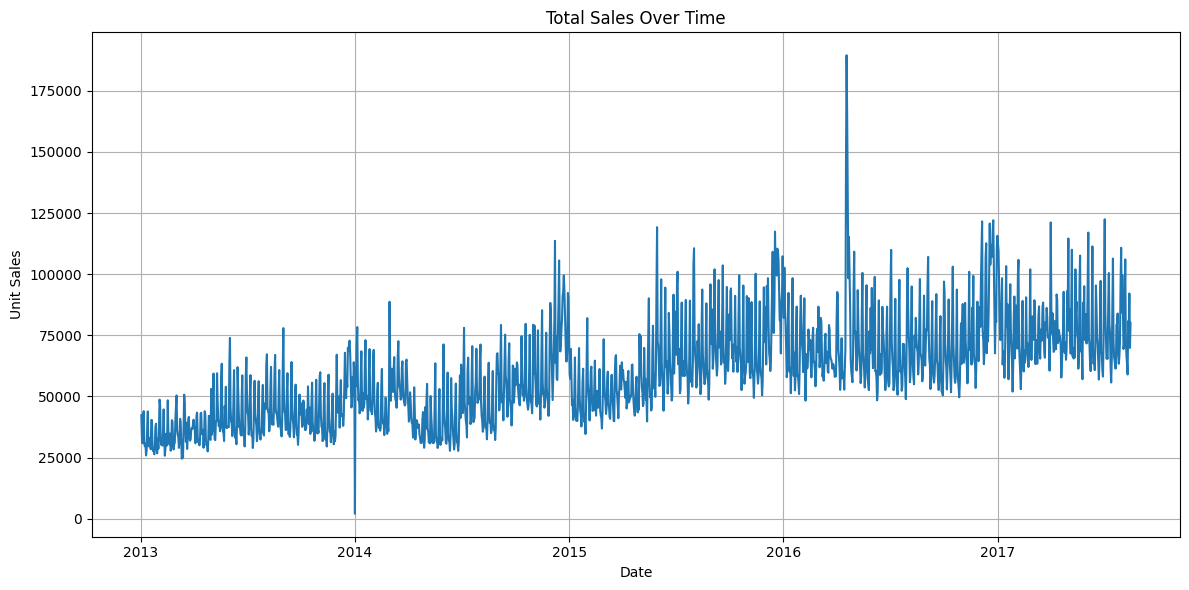

In [49]:
# Total daily sales across all selected stores and items
daily_sales = df.groupby('date')['unit_sales'].sum()

plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

**Insights:**

We can observe clear weekly patterns, with fluctuations that may reflect weekdays vs. weekends.

End-of-year peaks are visible, likely due to holidays like Christmas or New Year's.

There is a long-term upward trend, possibly indicating increased store traffic or seasonality.

###Time-based Features

In [50]:
# Add time-related features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week
0,2013-01-02,24,105574,12.0,False,2013,1,2,2
1,2013-01-02,24,105575,2.0,False,2013,1,2,2
2,2013-01-02,24,105577,1.0,False,2013,1,2,2
3,2013-01-02,24,105693,7.0,False,2013,1,2,2
4,2013-01-02,24,105737,17.0,False,2013,1,2,2


**Why this matters:**

These features are essential for capturing seasonality, weekly cycles, and potential holiday effects.

They can help models learn patterns tied to specific months (e.g., December) or weekdays (e.g., lower sales on Mondays).

### Weekly sales average (moving window)

In [51]:
# Calculate 7-day moving average for each item/store
df['unit_sales_7d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'] \
                            .transform(lambda x: x.rolling(7, min_periods=1).mean())
df[['date', 'store_nbr', 'item_nbr', 'unit_sales', 'unit_sales_7d_avg']].head(10)

,date,store_nbr,item_nbr,unit_sales,unit_sales_7d_avg
0,2013-01-02,24,105574,12.0,12.0
1,2013-01-02,24,105575,2.0,2.0
2,2013-01-02,24,105577,1.0,1.0
3,2013-01-02,24,105693,7.0,7.0
4,2013-01-02,24,105737,17.0,17.0
5,2013-01-02,24,105857,1.0,1.0
6,2013-01-02,24,106716,3.0,3.0
7,2013-01-02,24,108786,3.0,3.0
8,2013-01-02,24,108797,2.0,2.0
9,2013-01-02,24,108862,3.0,3.0


**Why it's useful:**

Helps to reduce random noise in daily sales.

Useful for modeling because it reflects more stable demand patterns.

The rolling average also captures local trends and helps understand short-term shifts.

### Analyze seasonality with heatmap

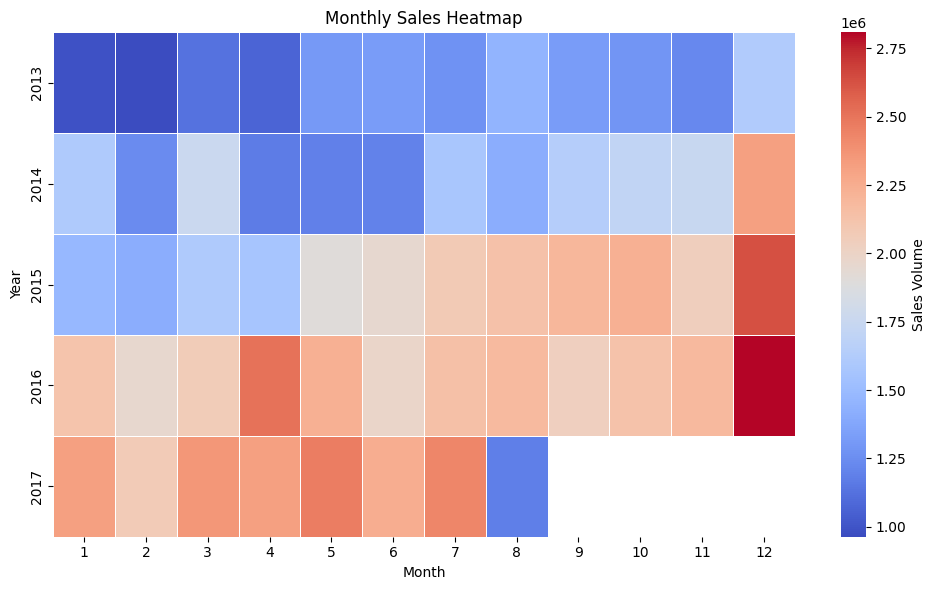

In [52]:
# Aggregate sales per year and month
monthly_sales = df.groupby(['year', 'month'])['unit_sales'].sum().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(monthly_sales, cmap='coolwarm', annot=False, linewidths=0.5, linecolor='white', cbar_kws={'label': 'Sales Volume'})
plt.title('Monthly Sales Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

**Insights:**

December and November usually show higher intensity, confirming the holiday season impact.

Mid-year months like June–August tend to have lower sales, suggesting possible seasonal dips.

This kind of seasonal heatmap supports decisions like increasing inventory during peak months.

### Holiday impact analysis

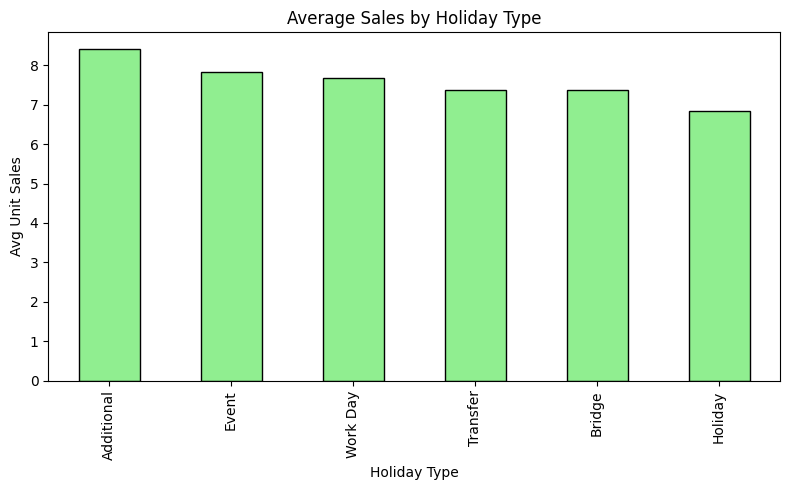

In [53]:
# Load holiday data
holidays = pd.read_csv('/content/drive/MyDrive/favorita/holidays_events.csv', parse_dates=['date'])

# Sample 500k rows with sales > 0 to keep it light
df_sample = df[df['unit_sales'] > 0].sample(n=500_000, random_state=42)

# Merge with holidays
df_sample = pd.merge(df_sample, holidays, on='date', how='left')

# Group by holiday type and calculate mean sales
holiday_sales = df_sample.groupby('type')['unit_sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average Sales by Holiday Type')
plt.xlabel('Holiday Type')
plt.ylabel('Avg Unit Sales')
plt.tight_layout()
plt.show()

**Insights:**

Sales are higher on local and national holidays, particularly during major public celebrations.

Some holidays (like Event or Work Day) don’t seem to boost sales much, or may even slightly reduce them.

Incorporating holiday type as a feature in models could improve demand forecasts during irregular periods.

# Modeling Preparation & Baseline Model

### Create lag features (lag_1, lag_7, lag_14)

In [54]:
# Lag features capture past sales behavior to improve model predictions

def create_lag_features(df, lags=[1, 7, 14]):
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(lag)
    return df

# Apply the function to the full dataset
# (Note: This will introduce NaNs for the first few days of each group)
df = create_lag_features(df)

### Create rolling mean feature (7-day window)

In [55]:
# Rolling averages help smooth out fluctuations and capture local trends

def create_rolling_mean(df, window=7):
    df[f'rolling_mean_{window}'] = (
        df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window).mean())
    )
    return df

df = create_rolling_mean(df)

In [56]:
# Extract time-based features
# Useful for modeling trends and seasonality

df['day_of_week'] = df['date'].dt.dayofweek.astype('int8')
df['month'] = df['date'].dt.month.astype('int8')
df['year'] = df['date'].dt.year.astype('int16')

In [57]:
# Drop rows with NaN values (caused by lag/rolling features)
# This ensures the model gets complete data only

df.dropna(inplace=True)

In [58]:
# Define features and target variable

features = [
    'store_nbr', 'item_nbr', 'onpromotion', 'day_of_week', 'month', 'year',
    'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7'
]
target = 'unit_sales'

In [59]:
# Split into training and validation sets
# We'll use a time-based split (e.g., last 30 days for validation)

cutoff_date = df['date'].max() - pd.Timedelta(days=30)
df_train_model = df[df['date'] <= cutoff_date]
df_valid_model = df[df['date'] > cutoff_date]

X_train = df_train_model[features]
y_train = df_train_model[target]
X_valid = df_valid_model[features]
y_valid = df_valid_model[target]

In [60]:
# Train a baseline XGBoost model

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Validation RMSE: 15.6919


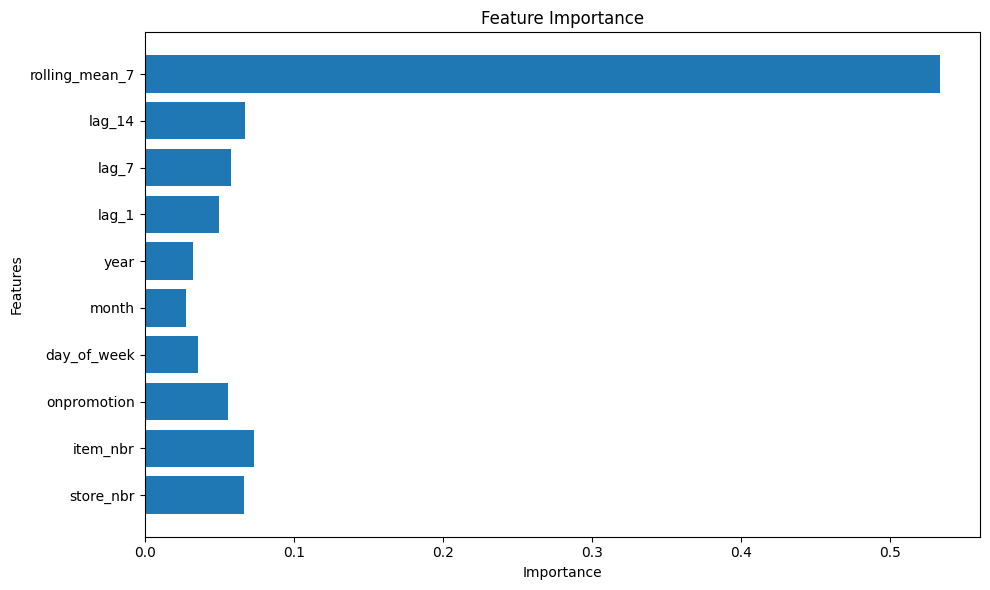

In [61]:
# Predict and evaluate using RMSE

y_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot feature importance

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(features, model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

**What it does:**

Visualizes how much each feature contributed to the predictive power of the model (e.g., XGBoost).

model.feature_importances_ returns the relative importance of each input feature.

**Interpretation:**

Features at the top of the chart are the most influential in determining sales predictions.

Commonly important features may include:

onpromotion: Indicates strong sales influence during promotions.

dayofweek, month, zscore: Capture time patterns and anomalies.

is_weekend, is_month_end: Help explain cyclic trends in customer behavior.

**Insight:**

 If some engineered features (like is_month_end) show low importance, they might be redundant or not useful. Conversely, if features like zscore or onpromotion rank high, it validates your preprocessing decisions.